# Смена директории

In [1]:
%cd ..

/Users/uzumnasiya/HSE/Year_Project


# Импорт библиотек

In [2]:
import logging
import warnings


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
import joblib
import shap
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from category_encoders import CatBoostEncoder
from catboost import CatBoostClassifier


from utils.dev_utils import get_pool
from utils.pipeline_utils import CustomPreprocessor
from utils.metrics import MetricCalculator, metric_funcs
from utils.style.styler import style_metrics
from utils.style.html_output import print_multiple_html
from utils.plot_utils import plot_gini_by_period_styled, plot_roc_by_masks

In [3]:
logging.getLogger().setLevel(logging.WARNING)
warnings.filterwarnings('ignore')
sns.set_palette('bright')


pd.options.display.float_format = "{:.2f}".format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

In [4]:
%load_ext autoreload
%autoreload 2
%aimport utils.plot_utils
%aimport utils.eda_utils
%aimport utils.style_utils
%aimport utils.psi
%aimport utils.style.styler

# Входные данные

## Загрузка данных

In [5]:
data = pd.read_parquet('./data/processed/data.pqt')

data.shape

(1097231, 494)

## Валидные переменные

In [6]:
path = r'./docs/valid_features.xlsx'
valid_features_data = pd.read_excel(path, index_col=False)

## Конфиги/константы

In [7]:
TARGET = 'target'
DATE_MONTH = 'date_month'
DATE_QUARTAL = 'date_quartal'

FEATURES = valid_features_data.loc[(valid_features_data['valid_flag'] == 1)]['attribute'].values
CAT_FEATURES = list(set(FEATURES) & set(data.select_dtypes(include=["object", "category"]).columns))
NUM_FEATURES = list(set(FEATURES) & set(data.select_dtypes(include=["number"]).columns))

TRAIN_MASK = (data['sample_type'] == 'TRAIN')
TEST_MASK = (data['sample_type'] == 'TEST')
OOT_MASK = (data['sample_type'] == 'OOT')

DEV_MASK = (data['competition_sample_type'] == 'TRAIN')

In [8]:
print_multiple_html(
    ('Кол-во переменных: ', len(FEATURES)),
    ('Кол-во категориальных переменных: ', len(CAT_FEATURES))
)

In [9]:
metr_funcs = {
    'roc_auc': metric_funcs.roc_auc_score_nan,
    'gini': metric_funcs.gini_score_nan,
    'precision': metric_funcs.precision,
    'recall': metric_funcs.recall
}

stats_funcs = {
    'obs_cnt': lambda y_true, data: len(y_true),
    'target_cnt': lambda y_true, data: sum(y_true),
    'DR': lambda y_true, data: sum(y_true) / len(y_true)
}

# Класс для расчета метрик
metr_calc = MetricCalculator(metr_funcs=metr_funcs, stats_funcs=stats_funcs)


STYLE_CONFIG = {
    'percent_cols': ['gini', 'roc_auc', 'DR', 'precision', 'recall'],
    'int_cols': ['obs_cnt', 'target_cnt'],
    'gradient_cols': ['gini', 'roc_auc', 'precision', 'recall'],
    'gradient_cmap': 'RdYlGn',
}

In [10]:
def metrics_split(data, group_cols, metr_calc, pred_cols=['lg_model_preds'], target='target', asc=True):
    """Упрощенный интерфес для расчета метрик"""

    metr_split = metr_calc.calculate(data, true_col=target, pred_cols=pred_cols, group_cols=group_cols)
    metr_split = (
        metr_split
        .sort_values(by=group_cols, ascending=asc)
        .set_index(group_cols)
    )
    
    return metr_split

# Обучение CatBoost

In [11]:
# Берем только наблюдения с взаимной целевой и преобразуем кат. фичи
dev_sample = data.loc[DEV_MASK].copy()

# Трансформируем категориальные переменные
dev_sample = CustomPreprocessor(cat_features=CAT_FEATURES).transform(dev_sample)

In [12]:
train_pool = get_pool(dev_sample, TARGET, TRAIN_MASK, FEATURES, CAT_FEATURES)
test_pool = get_pool(dev_sample, TARGET, TEST_MASK, FEATURES, CAT_FEATURES)
oot_pool = get_pool(dev_sample, TARGET, OOT_MASK, FEATURES, CAT_FEATURES)

In [13]:
# Параметры модели
default_params = {
    "iterations": 100,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "early_stopping_rounds": 20,
    "verbose": 0,
    "random_seed": 42,
}

In [14]:
# Обучение модели
model = CatBoostClassifier(**default_params, cat_features=CAT_FEATURES)
model.fit(train_pool, eval_set=test_pool, use_best_model=True, plot=False)

In [15]:
# Предсказания для всего набора
pipeline = Pipeline([
    ('preprocessor', CustomPreprocessor(cat_features=CAT_FEATURES)),
    ('model', model),
])

data['cb_model_preds'] = pipeline.predict_proba(data[FEATURES])[:, 1]

## Метрики

In [16]:
# По сэмплам
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='cb_model_preds',
    group_cols='sample_type',
    metr_calc=metr_calc,
    asc=False
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
sample_type,,,,,,,,
TRAIN,cb_model_preds,91.7%,83.4%,93.7%,46.1%,350 849,12 166,3.5%
TEST,cb_model_preds,90.9%,81.8%,91.1%,43.4%,150 365,5 383,3.6%
OOT,cb_model_preds,88.5%,76.9%,65.4%,34.5%,89 326,3 114,3.5%


In [17]:
# По месяцам
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='cb_model_preds',
    group_cols=DATE_MONTH,
    metr_calc=metr_calc,
    asc=True
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
date_month,,,,,,,,
2020-01,cb_model_preds,91.1%,82.1%,87.8%,42.6%,134 339,3 401,2.5%
2020-02,cb_model_preds,91.9%,83.7%,94.9%,45.8%,86 467,3 469,4.0%
2020-03,cb_model_preds,92.1%,84.1%,94.7%,51.5%,95 121,3 832,4.0%
2020-04,cb_model_preds,91.1%,82.2%,93.6%,43.5%,98 615,3 898,4.0%
2020-05,cb_model_preds,91.1%,82.3%,92.8%,41.8%,86 672,2 949,3.4%
2020-06,cb_model_preds,88.4%,76.8%,65.4%,34.4%,86 572,2 995,3.5%
2020-07,cb_model_preds,89.9%,79.7%,66.2%,37.8%,2 754,119,4.3%


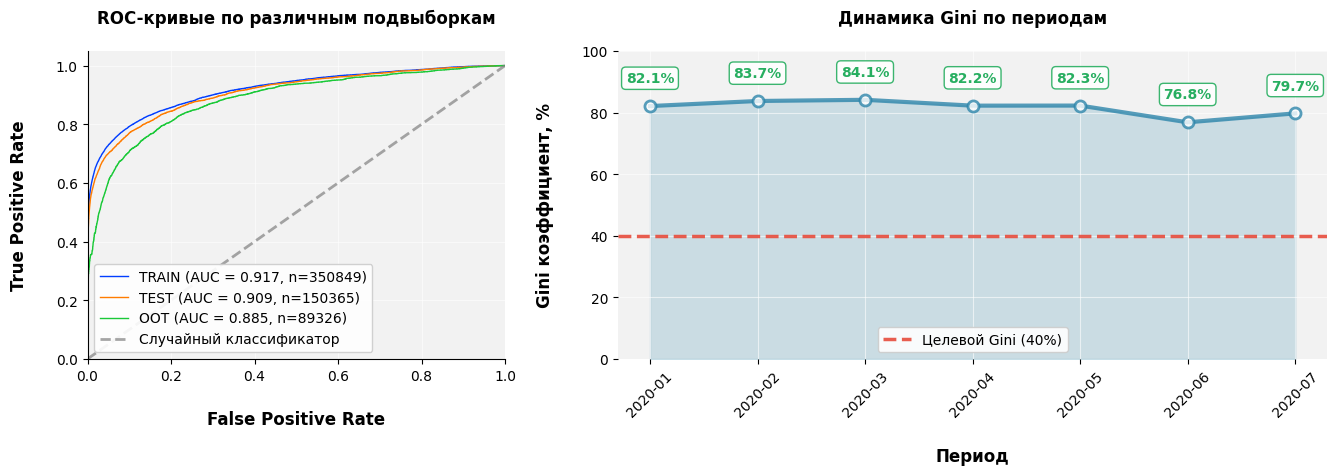

In [18]:
# Графики распределения таргета по выборкам
fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1.7]})
masks_dict = {'TRAIN': TRAIN_MASK, 'TEST': TEST_MASK, 'OOT': OOT_MASK}

ax = axes[0]
plot_roc_by_masks(data, TARGET, 'cb_model_preds', masks_dict, 
                     figsize=(8, 4), palette='bright', 
                     title='ROC-кривые по различным подвыборкам',
                     ax=ax)

ax = axes[1]
plot_gini_by_period_styled(metr_split.reset_index(), 'gini', DATE_MONTH,
                              figsize=(8, 4), 
                              target_gini=40,
                              title='Динамика Gini по периодам',
                              ax=ax)

# Отбор переменных

In [19]:
importances_df = pd.DataFrame({
    'Feature': model.feature_names_,
    'Importance': model.get_feature_importance()
}).sort_values('Importance', ascending=False)

importances_df.head(8)

,Feature,Importance
24,C13,5.46
319,V294,3.69
7,card6,3.57
13,C1,3.56
3,card2,3.38
25,C14,3.24
131,V91,3.22
0,TransactionAmt,2.89


In [20]:
# Далее используем важные переменные
IMP_SHORT_FEATURES = importances_df[importances_df['Importance'] > 0.01]['Feature'].to_list()
IMP_CAT_FEATURES = [i for i in CAT_FEATURES if i in IMP_SHORT_FEATURES]

print_multiple_html(
    (f"Кол-во важных фичей (total): ", len(IMP_SHORT_FEATURES)),
    (f"Кол-во важных категориальных фичей: ", len(IMP_CAT_FEATURES)),
)

In [21]:
# Для простоты берем топ-30
FINAL_FEATURES = importances_df.loc[importances_df['Feature'].isin(IMP_SHORT_FEATURES)][:30]['Feature'].to_list()
FINAL_CAT_FEATURES = [i for i in IMP_CAT_FEATURES if i in FINAL_FEATURES]

In [22]:
print_multiple_html(
    (f"Кол-во финальных фичей: ", len(FINAL_FEATURES)),
    (f"Кол-во финальных категориальных фичей: ", len(FINAL_CAT_FEATURES)),
)

In [23]:
# Сохраняем переменные
features = {
    'FINAL_FEATURES': FINAL_FEATURES,
    'FINAL_CAT_FEATURES': FINAL_CAT_FEATURES
}

with open(r'./models/params/features.yaml', 'w', encoding='utf-8') as file:
    yaml.dump(features, file, allow_unicode=True, default_flow_style=False)

# Подбор гиперпараметров


In [24]:
# Обновляем пулы данных
train_pool = get_pool(dev_sample, TARGET, TRAIN_MASK, FINAL_FEATURES, FINAL_CAT_FEATURES)
test_pool = get_pool(dev_sample, TARGET, TEST_MASK, FINAL_FEATURES, FINAL_CAT_FEATURES)
oot_pool = get_pool(dev_sample, TARGET, OOT_MASK, FINAL_FEATURES, FINAL_CAT_FEATURES)

In [25]:
def objective(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 100, 500),                                # Количество деревьев в бустинге
        'depth': trial.suggest_int('depth', 4, 7),                                             # Глубина деревьев
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),            # Скорость обучения
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),              # Выборка признаков на каждом уровне дерева 
        'verbose': False,
        'random_state': 42
    }

    catboost = CatBoostClassifier(**params)
    catboost.fit(train_pool, plot=False)
    
    roc_auc = roc_auc_score(data[TEST_MASK][TARGET], catboost.predict_proba(test_pool)[:, 1])
    return roc_auc


In [26]:
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=10, show_progress_bar=False)

[I 2025-12-08 13:24:25,709] A new study created in memory with name: no-name-cd2d5807-922f-42bd-82c2-f819075df744
[I 2025-12-08 13:24:49,022] Trial 0 finished with value: 0.9048330714133531 and parameters: {'iterations': 250, 'depth': 7, 'learning_rate': 0.1205712628744377, 'colsample_bylevel': 0.0638792635777333}. Best is trial 0 with value: 0.9048330714133531.
[I 2025-12-08 13:25:00,512] Trial 1 finished with value: 0.8392748508361533 and parameters: {'iterations': 162, 'depth': 4, 'learning_rate': 0.012184186502221764, 'colsample_bylevel': 0.08795585311974417}. Best is trial 0 with value: 0.9048330714133531.
[I 2025-12-08 13:25:37,493] Trial 2 finished with value: 0.8683154176995044 and parameters: {'iterations': 341, 'depth': 6, 'learning_rate': 0.010725209743171997, 'colsample_bylevel': 0.0972918866945795}. Best is trial 0 with value: 0.9048330714133531.
[I 2025-12-08 13:26:01,154] Trial 3 finished with value: 0.8428459053228239 and parameters: {'iterations': 433, 'depth': 4, 'lea

In [27]:
final_params = {**default_params, **study.best_params}
final_params

{'iterations': 250,
 'loss_function': 'Logloss',
 'eval_metric': 'AUC',
 'early_stopping_rounds': 20,
 'verbose': 0,
 'random_seed': 42,
 'depth': 7,
 'learning_rate': 0.1205712628744377,
 'colsample_bylevel': 0.0638792635777333}

In [28]:
# Сохраняем параметры
with open(r'./models/params/best_params.yaml', 'w', encoding='utf-8') as file:
    yaml.dump(final_params, file)

# Обучение финальной модели

In [29]:
# Создаем пулы данных
train_pool = get_pool(dev_sample, TARGET, TRAIN_MASK, FINAL_FEATURES, FINAL_CAT_FEATURES)
test_pool = get_pool(dev_sample, TARGET, TEST_MASK, FINAL_FEATURES, FINAL_CAT_FEATURES)
oot_pool = get_pool(dev_sample, TARGET, OOT_MASK, FINAL_FEATURES, FINAL_CAT_FEATURES)

In [30]:
# Создаем и обучаем модель
final_model = CatBoostClassifier(**final_params, cat_features=FINAL_CAT_FEATURES)
final_model.fit(train_pool, eval_set=test_pool)

In [31]:
# Предсказания для dev_sample
dev_sample['final_model_preds'] = final_model.predict_proba(dev_sample[FINAL_FEATURES])[:, 1]

In [32]:
# # Предсказания для всего набора
pipeline = Pipeline([
    ('preprocessor', CustomPreprocessor(cat_features=FINAL_CAT_FEATURES)),
    ('model', final_model),
])

data['final_model_preds'] = pipeline.predict_proba(data[FINAL_FEATURES])[:, 1]

## Метрики финальной модели

In [33]:
# По сэмплам
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='final_model_preds',
    group_cols='sample_type',
    metr_calc=metr_calc,
    asc=False
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
sample_type,,,,,,,,
TRAIN,final_model_preds,91.1%,82.1%,92.3%,41.0%,350 849,12 166,3.5%
TEST,final_model_preds,90.5%,81.0%,90.2%,38.7%,150 365,5 383,3.6%
OOT,final_model_preds,88.3%,76.6%,80.6%,31.0%,89 326,3 114,3.5%


In [34]:
# По месяцам
metr_split = metrics_split(
    data=data.loc[DEV_MASK],
    target=TARGET,
    pred_cols='final_model_preds',
    group_cols=DATE_MONTH,
    metr_calc=metr_calc,
    asc=True
)

style_metrics(metr_split, STYLE_CONFIG)

,level_1,roc_auc,gini,precision,recall,obs_cnt,target_cnt,DR
date_month,,,,,,,,
2020-01,final_model_preds,90.4%,80.9%,86.5%,37.4%,134 339,3 401,2.5%
2020-02,final_model_preds,91.2%,82.3%,94.4%,41.6%,86 467,3 469,4.0%
2020-03,final_model_preds,91.8%,83.6%,94.0%,46.7%,95 121,3 832,4.0%
2020-04,final_model_preds,90.6%,81.2%,92.2%,37.8%,98 615,3 898,4.0%
2020-05,final_model_preds,90.4%,80.7%,90.4%,37.1%,86 672,2 949,3.4%
2020-06,final_model_preds,88.2%,76.4%,80.6%,30.9%,86 572,2 995,3.5%
2020-07,final_model_preds,90.7%,81.3%,81.2%,32.8%,2 754,119,4.3%


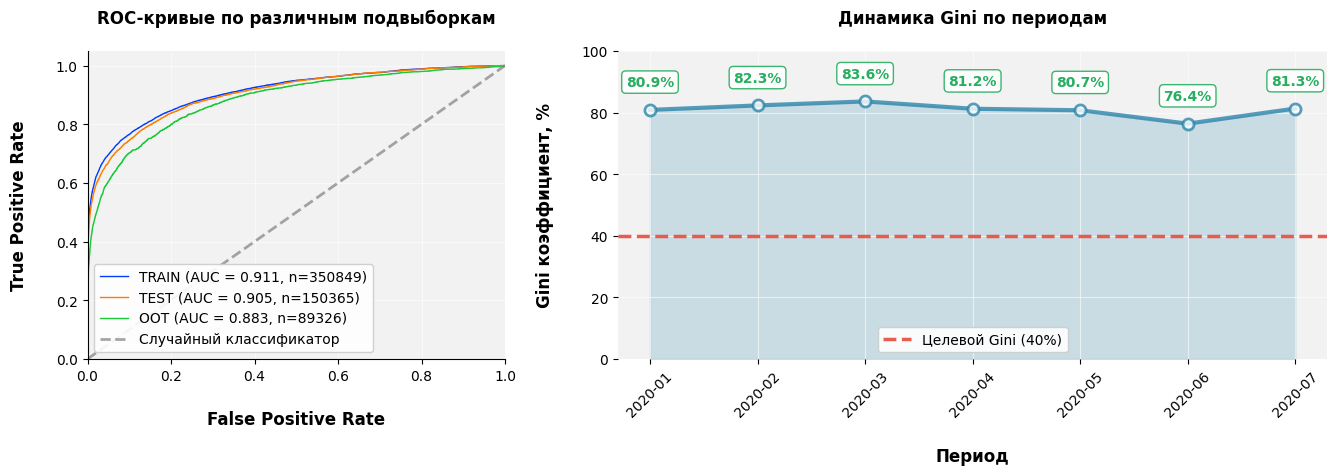

In [35]:
# Графики распределения таргета по выборкам
fig, axes = plt.subplots(1, 2, figsize=(16, 4), gridspec_kw={'width_ratios': [1, 1.7]})
masks_dict = {'TRAIN': TRAIN_MASK, 'TEST': TEST_MASK, 'OOT': OOT_MASK}

ax = axes[0]
plot_roc_by_masks(data, TARGET, 'final_model_preds', masks_dict, 
                     figsize=(8, 4), palette='bright', 
                     title='ROC-кривые по различным подвыборкам',
                     ax=ax)

ax = axes[1]
plot_gini_by_period_styled(metr_split.reset_index(), 'gini', DATE_MONTH,
                              figsize=(8, 4), 
                              target_gini=40,
                              title='Динамика Gini по периодам',
                              ax=ax)

# Сохранение модели

In [36]:
final_model.save_model(r'./models/final_model.cbm')
joblib.dump(pipeline, r'./models/pipeline.joblib')

['./models/pipeline.joblib']

# SHAP переменных

In [37]:
# Создаем explainer
explainer = shap.TreeExplainer(final_model)

# Вычисляем SHAP значения для разных выборок
shap_cb_train = explainer(
    dev_sample.loc[TRAIN_MASK, FINAL_FEATURES],
    dev_sample.loc[TRAIN_MASK, TARGET]
)

shap_cb_test = explainer(
    dev_sample.loc[TEST_MASK, FINAL_FEATURES],
    dev_sample.loc[TEST_MASK, TARGET]
)

shap_cb_oot = explainer(
    dev_sample.loc[OOT_MASK, FINAL_FEATURES],
    dev_sample.loc[OOT_MASK, TARGET]
)

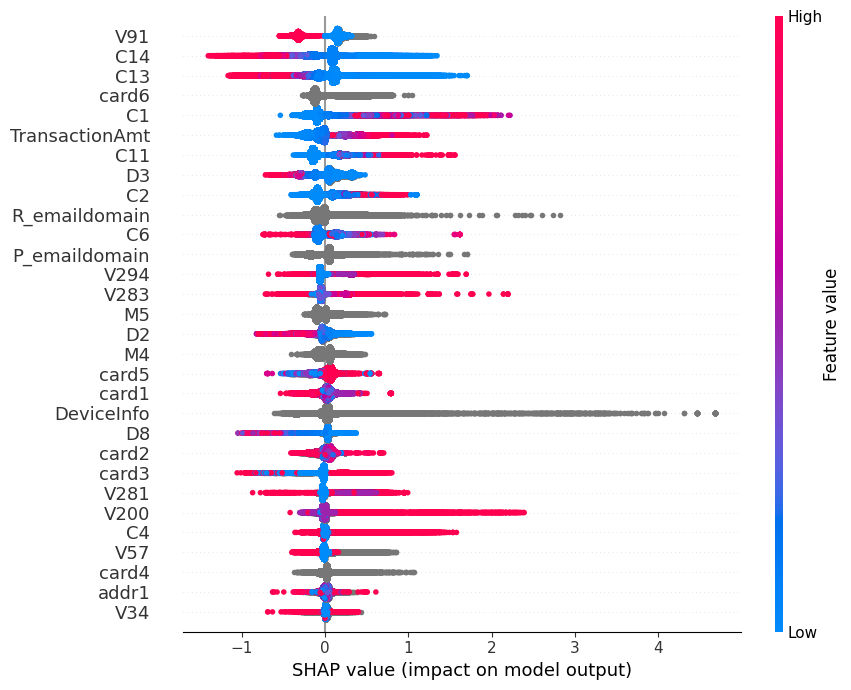

In [38]:
# Создаем summary plot
shap.summary_plot(
    shap_cb_test,
    dev_sample.loc[TEST_MASK, FINAL_FEATURES],
    feature_names=FINAL_FEATURES,
    plot_type="dot",
    max_display=len(FINAL_FEATURES),
    plot_size=(9, 7),
    show=False
)

# Сохраняем график
# path = r"reports/plots/shap.png"
# plt.savefig(path, bbox_inches="tight", pad_inches=0.1)